In [1]:
from assignment2 import *
pd.options.display.float_format = '{:,.4f}'.format

Remise électronique sur ZoneCours au plus tard le **14 avril à 23h55** de:

* Ce Jupyter notebook (.ipynb) en guise de rapport, une fois les réponses ajoutées. 
* **Tous** les fichiers *.py* nécessaires pour l'exécution du notebook

Le rapport **doit**:

* être en format .ipynb (des points seront enlevés pour tout autre format).
* inclure le numéro de matricule de tous les membres de l'équipe dans la première cellule (i.e. remplacez ces consignes)
* répondre aux questions et discuter des résultats à l'aide de tables, graphiques, et cellules markdown

Barème:

* **35%** Exactitude des résultats
* **25%** Discussions complètes et **concises** (cellules ``markdown'')
* **20%** Concision du notebook (.ipynb avec minimum de code) et clarté des tables & graphiques
* **20%** Clarté du code (.py)

Dans les tables, présentez 4 décimales après le point.

# Question 1

Nous considérons des données historiques d'options sur le S&P 500. Le fichier suivant sont dans le répertoire courant:
```
215K 28 Mar 20:48 distrd_108105.csv
2.7M 28 Mar 21:01 opprcd200201_108105.csv
 63K 28 Mar 21:02 opprcd961203_108105.csv
511K 28 Mar 20:45 secprd_108105.csv
9.3M 28 Mar 20:43 zerocd.csv
```

Les `secprd_108105.csv` et `zerocd.csv` contiennent, respectivement, les données sur le sous-jacent et la courbe des taux sans risque (capitalisés continuement). La fonction `get_log_excess_returns` (fournie dans `assignment2.py`). 

In [2]:
days_in_year = 252
log_xreturns = get_log_excess_returns(days_in_year)

In [3]:
log_xreturns

date
1996-01-02       NaN
1996-01-03    0.0007
1996-01-04   -0.0061
1996-01-05   -0.0018
1996-01-08    0.0026
               ...  
2021-12-27    0.0137
2021-12-28   -0.0010
2021-12-29    0.0014
2021-12-30   -0.0030
2021-12-31   -0.0027
Name: log_xret, Length: 6547, dtype: float64

Utilisez les paramètres initiaux suivants pour démarrer l'estimation des paramètres d'un modèle NGARCH en date du 1996-12-31. Utilisez la notation suivante:

\begin{align*}
r_{t+1} - r_{f} &= \lambda \sqrt{h_{t+1}}-\frac{1}{2}h_{t+1}+\sqrt{h_{t+1}}%
\varepsilon _{t+1}, \\
h_{t+1}& =\omega +\alpha h_{t}\left( \varepsilon _{t}-\gamma \right)
^{2}+\beta h_{t}
\end{align*}

Quels paramètres obtenez vous en maximisant la vraisemblance des rendements au 1996-12-31? Répétez l'exercice au 2020-02-01. Tabulez les paramètres de façon à pouvoir comparer les deux jeux de paramètres aisément. Ajoutez à votre table 

- la volatilité inconditionnelle (annualisée)
- la volatilité conditionnelle (annualisée) prédite au lendemain de l'estimation
- la correlation conditionnelle en $t$ entre $r_{t+1}$ et $h_{t+2}$
- la volatilité conditionnelle en $t$ de la variance $h_{t+2}$

que les paramètres impliques. De plus, inspirez-vous de la `note_on_erp.ipynb` et définissez une fonction:
```
def plot_var_forecasts(horizon, P, Q, annualized=False):
```
que vous appelerez avec `annualized=True` sur des simulations résultant des deux différents jeux de paramètres. Discutez des paramètres, des figures et des implications aux point de vue de la validité de la spécification (vs *misspecification*) du NGARCH.

,λ,ω,α,β,γ,Vol. incond.,Vol. cond. @ t+1,Corr. cond. @ t,Vol. cond. @ t de h_t+2
1996-12-31,2.0380e-02,3.8228e-07,3.0018e-03,9.0123e-01,5.4632,0.1249,0.1088,-0.9917,1.5542e-06
2020-02-01,3.5727e-02,9.5237e-07,6.3411e-02,8.5253e-01,1.1179,0.2231,0.1407,-0.8451,1.3170e-05


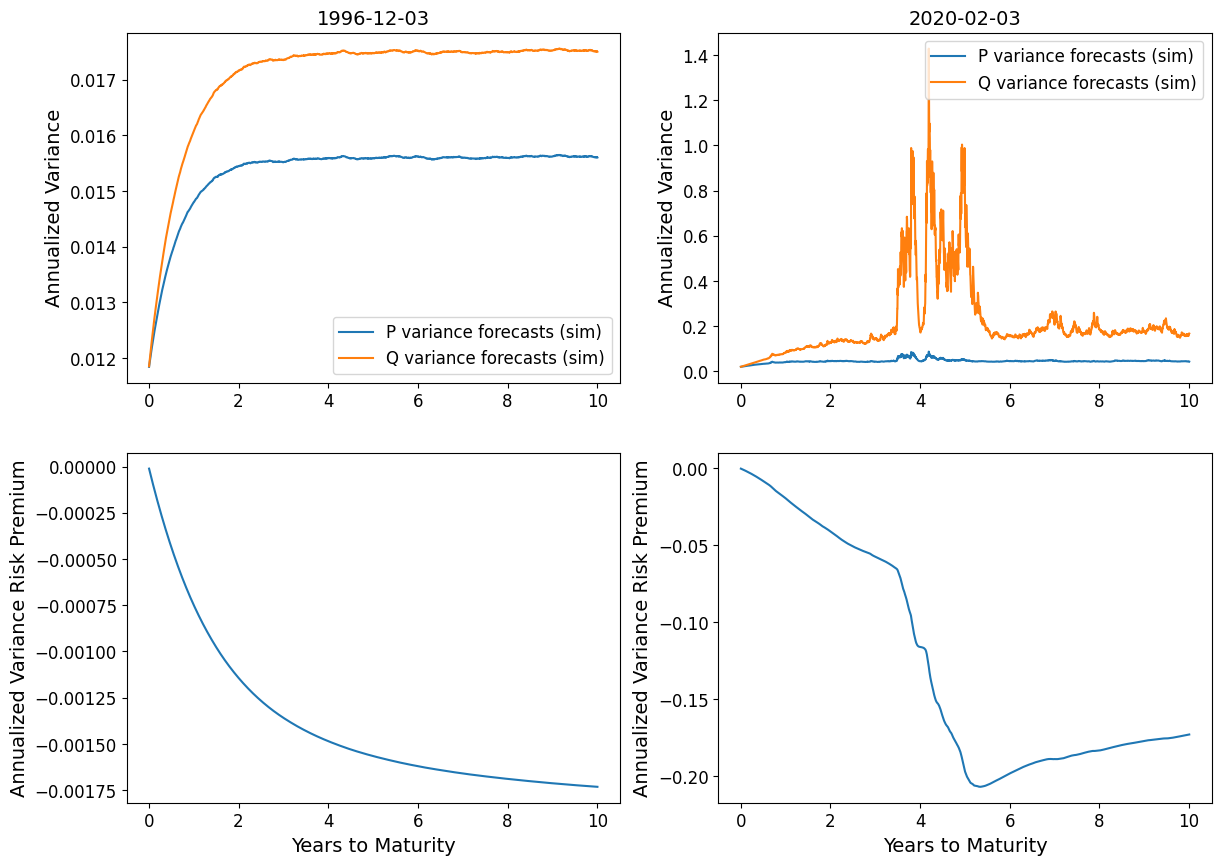

In [4]:
# Inputs pour initialiser le MLE
time_t = np.datetime64('1996-12-31')
ng1996 = ngarch.initialize_at(time_t, log_xreturns, days_in_year)

time_t = np.datetime64('2020-02-01')
ng2020 = ngarch.initialize_at(time_t, log_xreturns, days_in_year)

# MLE + nouveaux paramètres NGARCH
ng1996 = f_NGARCH(ng1996)
ng2020 = f_NGARCH(ng2020)

# Table de sortie
out_Q1 = f_out_format_Q1([ng1996, ng2020])

# Inputs pour les simulations
n_days  = 10*days_in_year
n_paths = 10000

# Simulation sous P
P_1996 = measure( *ng1996.simulateP(100, n_days, n_paths, ng1996.P_predict_h()))
P_2020 = measure( *ng2020.simulateP(100, n_days, n_paths, ng2020.P_predict_h(), P_1996.z))

# Simulation sous Q
Q_1996 = measure( *ng1996.simulateQ(100, n_days, n_paths, ng1996.Q_predict_h(), P_1996.z))
Q_2020 = measure( *ng2020.simulateQ(100, n_days, n_paths, ng2020.Q_predict_h(), P_1996.z))

# Graphique des variances conditionnelles prévues
horizon = np.arange(1,n_days+2) / days_in_year
plot    = plot_var_forecasts2(horizon = horizon, P = [P_1996, P_2020], Q = [Q_1996, Q_2020], annualized=True)
out_Q1

La volatilité conditionnelle sous Q est généralement supérieure à celle sous P en raison de l'aversion au risque des investisseurs. Les investisseurs exigent une prime de risque pour détenir des actifs risqués et cette prime est intégrée dans la tarification des produits dérivés. La volatilité sous Q reflète cette prime de risque en étant plus élevée que la volatilité sous P, car les investisseurs anticipent un niveau de risque plus élevé lorsqu'ils évaluent les produits dérivés (aussi appelée prime de volatilité).

# Question 2

Nous souhaitons tarifer les options aux deux dates pour lesquelles nous avons estimé les paramètres ci-haut. Avant de procédez, comparer qualitativement les deux jeux de données. Soutenez votre propos à l'aide de statistiques descriptives (tables) et de figures au besoin. Quels filtres devrait-on appliquer aux données avant procéder à la tarification des options? Justifier.

In [5]:
# Construction de la table descriptive
option_info = read_and_concatenate_options('opprcd961203_108105.csv', 'opprcd200201_108105.csv')
spx = load_price()

f_describe_table(option_info, spx).dropna(axis=1)

strike_price                       impl_volatility         \
                          count        min        max             min    50%   
date       cp_flag                                                             
1996-12-03 C           141.0000   475.0000   850.0000          0.0934 0.1727   
           P           184.0000   375.0000   850.0000          0.1478 0.2115   
2020-02-03 C         6,452.0000 1,200.0000 4,800.0000          0.0972 0.1914   
           P         7,837.0000   100.0000 4,300.0000          0.0626 0.2269   

                            delta                     DTM                      \
                      max     min     50%     max     min      50%        max   
date       cp_flag                                                              
1996-12-03 C       0.2559  0.0285  0.6633  0.9709 18.0000 109.0000   564.0000   
           P       1.0661 -0.8795 -0.2187 -0.0007 18.0000 109.0000   564.0000   
2020-02-03 C       0.6493  0.0004  0.7350  0.9994  2.0000  60.0000 1,047.0000   
           P       2.8973 -0.9948 -0.1404 -0.0000  2.0000  53.0000 1,047.0000   

                      K/S                
                      min    50%    max  
date       cp_flag                       
1996-12-03 C       0.6348 0.9756 1.1359  
           P       0.5011 0.9355 1.1359  
2020-02-03 C       0.3694 0.9588 1.4774  
           P       0.0308 0.9188 1.3235

La première étape, avant même de construire la table de statistiques descriptives, a été d'enlever les données pour lesquelles on a une volatilité implicite manquante et filtrer les lignes identiques. Ce sont les premiers filtres à appliquer aux données avant la tarification. Il est ensuite possible de comparer les deux jeux de données à l'aide de la table ci-dessus.

Le premier constat frappant est la différence entre le nombre d'option pour lesquels on a des données. En effet, il y en a plus de 43 fois plus en 2020 qu'en 1996. L'intervalle de prix d'exercice possible a aussi beaucoup augmenté. Par exemple, pour les puts, on voit que le prix d'exercice minimal est plus bas en 2020 qu'en 1996, et ce, malgré le fait que le prix du S&P500 a beaucoup augmenté depuis. Ce phénomène est aussi observable à travers l'augmentation des valeurs maximales de volatilité implicite entre 1996 et 2020. Finalement, il y a aussi un écart entre les maturités offertes. On peut observer que des options autant à plus courte qu'à plus longue échéance sont disponibles en 2020 par rapport à 1996.

Pour ce qui est des autres filtres à appliquer aux données avant la tarification, on doit premièrement s'assurer qu'il n'y a pas d'options avec une volatilité implicite extrême. En effet, une volatilité implicite extrême tend à ne pas représenter les vraies attentes des participants du marché. Nous fixerons à 125% la volatilité maximale pour laquelle on garde les données des options. Ensuite, on doit simplement s'assurer qu'il n'y a pas d'incohérence dans les données du delta (delta des calls entre 0 et 1 avec delta des puts entre -1 et 0). Le dernier filtre à appliquer sera sur le temps à maturité des options. Sachant que des options à très court terme peuvent se comporter de manière anormal, nous allons filtrer ceux avec une maturité de moins de 7 jours (une semaine). Nous allons aussi filtrer les options avec de très longue maturité car celles-ci manquent souvent de liquidité. La contrainte maximale pour la maturité sera de 550 jours (environ 1 an et demi).

Il reste maintenant à appliquer les filtrations décrites. Or, on s'apperçoit à l'aide de la table descriptive qu'il sera seulement nécessaire de filtrer les données de 2020 par rapport au temps restant avant la maturité. C'est ce qui est fait ci-dessous.


In [6]:
# Filtration des données
option_info = f_clean_table(option_info, spx, keep_moneyness=True).reset_index(drop=True)
option_info

,date,exdate,cp_flag,strike_price,volume,best_bid,mean_bidask,open_interest,impl_volatility,DTM,K/S
0,1996-12-03,1997-12-20,P,550.0000,0.0000,5.6250,6.1250,"3,497.0000",0.2449,382,0.7350
1,1996-12-03,1997-12-20,P,750.0000,"1,118.0000",41.3750,42.3750,"2,131.0000",0.1792,382,1.0023
2,1996-12-03,1997-03-22,P,650.0000,22.0000,5.6250,5.8750,"27,930.0000",0.2444,109,0.8687
3,1996-12-03,1997-02-22,P,700.0000,505.0000,9.6250,9.8750,"1,182.0000",0.2168,81,0.9355
4,1996-12-03,1997-06-21,C,685.0000,0.0000,87.3750,87.8750,419.0000,0.2001,200,0.9154
...,...,...,...,...,...,...,...,...,...,...,...
10882,2020-02-03,2020-12-31,P,"3,650.0000",0.0000,415.4000,424.5000,0.0000,0.1064,332,1.1235
10883,2020-02-03,2020-12-31,P,"3,700.0000",0.0000,457.2000,466.3500,0.0000,0.1015,332,1.1388
10884,2020-02-03,2020-12-31,P,"3,750.0000",0.0000,500.8000,509.9000,0.0000,0.0953,332,1.1542
10885,2020-02-03,2020-12-31,P,"3,800.0000",0.0000,545.9000,555.0000,0.0000,0.0866,332,1.1696


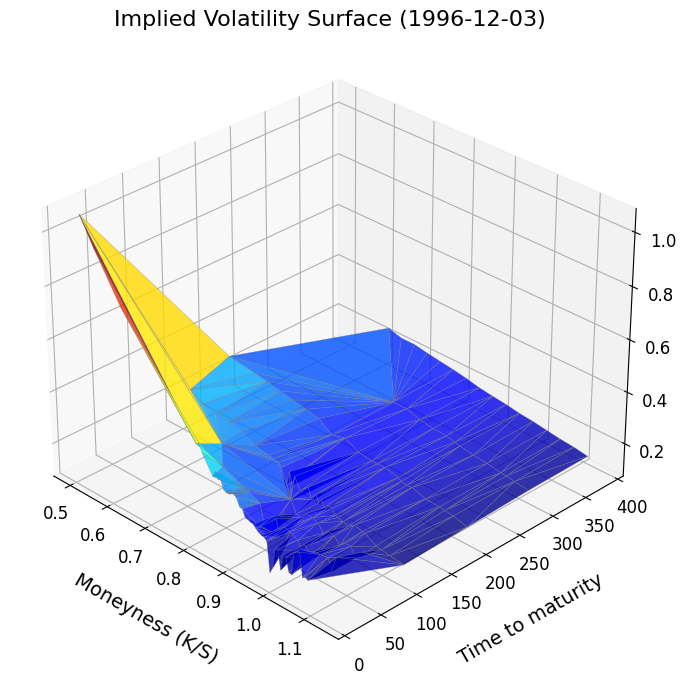

In [7]:
plot_iv_surface3d(option_info, date="1996-12-03")

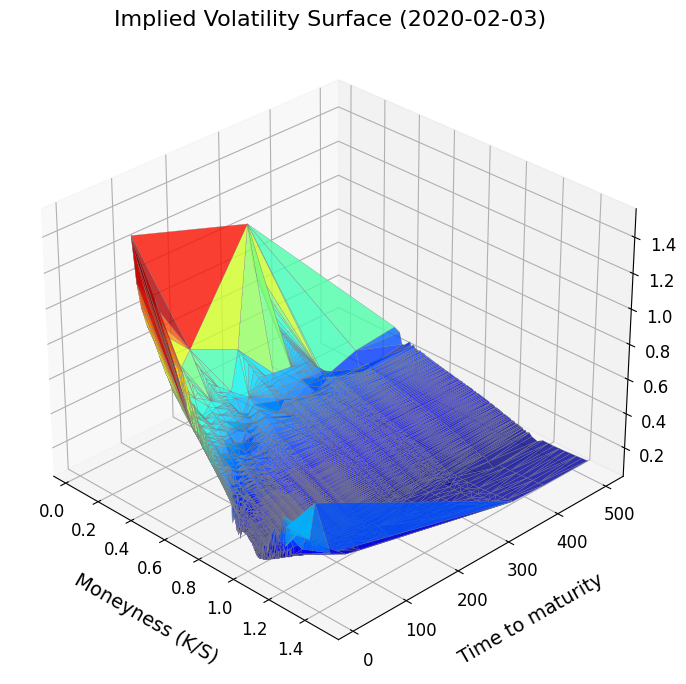

In [8]:
plot_iv_surface3d(option_info, date="2020-02-03")

# Question 3

Afin de tarifer les options, nous devons calculer, pour chaque paire $(t,T)$, le prix ex-dividendes du sous-jacent. Dans le cas du S&P 500, deux options s'offre à nous:

1. Utiliser en $t$ le taux de dividende prévu ($y$, en termes annuels) par OptionMetrics pour calculer $S(t) e^{-y(T-t)}$.

2. Utiliser l'approche du Cboe pour calculer le option-implied forward price $F(t,T)$ et la courbe des taux fournis par OptionMetrics (`zerocd.csv`). Ensuite, calculer le ex-dividend price $F(t,T) e^{-r_{t,T} (T-t)}$, où $r_{t,T}$ est le taux sans risque à $t$ pour une maturité à $T$, 

Comparer les résultats obtenus à les des deux approches. Comment et pourquoi diffèrent-ils selon vous?

In [9]:
option_info = read_and_concatenate_options('opprcd961203_108105.csv', 'opprcd200201_108105.csv')
option_info = f_clean_table(option_info, spx).reset_index(drop=True)

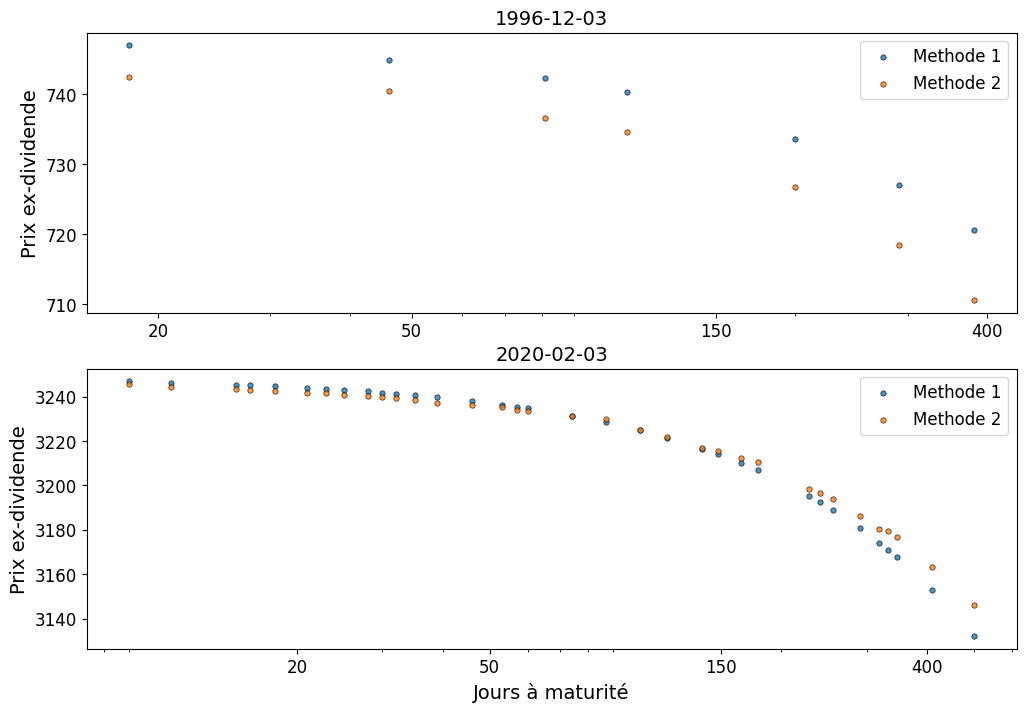

In [10]:
# Ajouter les prix, les dividendes, les rf et la moneyness à option_info
f_add_Q3_info(option_info, days_in_year)

# Méthode 1
exdiv_1 = option_info.S_t * np.exp(-option_info.y_t * (option_info.DTM)/days_in_year)
option_info['exdiv_1'] = exdiv_1

# Méthode 2
option_info = f_F_CBOE(option_info, days_in_year)
exdiv_2     = option_info.F_CBOE * np.exp(-option_info.r_f * (option_info.DTM)/days_in_year)
option_info['exdiv_2'] = exdiv_2

# Enlever les maturités pour lesquelles on ne peut pas calculer le forward CBOE
option_info.dropna(subset=['exdiv_2'], how='any', inplace=True)

# Graphique de comparaison
comp_plot = f_plot_Q3_comparison(option_info)

comparison_df = create_comparison_df(option_info)

In [11]:
comparison_df

,DTM_2020,EX1_2020,EX2_2020,DIFF,DIFF_BOOL
0,9,"3,132.2418","3,146.0987",-13.8569,False
1,11,"3,153.1189","3,163.2959",-10.177,False
2,15,"3,167.6538","3,176.8554",-9.2017,False
3,16,"3,171.1243","3,179.5088",-8.3845,False
4,18,"3,174.1352","3,180.3289",-6.1937,False
5,21,"3,180.6299","3,186.2481",-5.6183,False
6,23,"3,188.7669","3,193.8484",-5.0815,False
7,25,"3,192.4936","3,196.7904",-4.2967,False
8,28,"3,195.2915","3,198.5724",-3.2808,False
9,30,"3,206.7418","3,210.605",-3.8632,False


La première chose importante à noter est que, à cause des filtres appliqués à la question 2, on ne pouvait pas évaluer le option-implied forward price à l'aide de la méthode CBOE pour un nombre de jours à maturité de 179 (2020-02-03). En effet, il n'y avait pas au moins un prix d'exercice pour lequel on avait un call et un put à cette maturité. Les options pour cette maturité et pour la date d'évaluation du 2020-02-03 ne pourront donc malheureusement pas être analysées à cause de la nature des questions suivantes.

Pour ce qui est de la comparaison entre les deux méthodes, il est possible d'observer dans les graphiques précédents qu'il y a toujours une différence. Pour les données de 1996, la méthode 1 donne toujours un prix ex-dividende supérieur à la méthode 2. Pour ce qui est des données de 2020, c'est seulement vrai pour des maturités jusqu'à 74 jours. De plus, pour cette maturité, les prix donnés par les deux méthodes sont presque identiques. Pour des maturités plus grandes, c'est la méthode 2 qui donne des prix ex-dividendes plus élevés. Il est aussi intéressant de noter que pour de longues maturités, l'écart entre les deux méthodes s'accentuent (aautant en 2020 qu'en 1996).

D'ailleurs, le fait que les deux méthodes ne donne pas le même résultat pour le prix ex-dividende est logique. En effet, pour que ce soit le cas, il aurait fallu que pour chacune des maturités, il existe au moins un put ou un call pour lequel la moneyness(K/F) est exactement de 1. Cela aurait fait en sorte que l'approche du CBOE (méthode 2) coincide avec l'approche théorique (méthode 1). En d'autres mots, il aurait fallu une différence nulle entre le prix d'un put et d'un call de même strike pour que la méthode 2 coincide avec la méthode 1. Or, comme c'est jamais exactement le cas, il y a toujours une différence entre les deux méthodes.

# Question 4

Notez que sous BMS, un call
\begin{align*}
 c(t,T,K) &= \hat{S}(t) N(d_1) - Ke^{-r_f(T-t)} N(d_2) \\
% \textrm{avec} 
 d_i &= \frac{\log\frac{\hat{S}(t)}{K} + \left(r_f \pm \frac{1}{2}\sigma^2 \right) (T-t)
     }{\sigma\sqrt{T-t}}
\end{align*}
avec $\hat{S}(t) = S(t)e^{-y(T-t)} = F(t,T)e^{-r_f(T-t)}$. L'argument est similaire pour un put. On peut donc calculer les volatilités implicites de chaque option avec l'approche utilisée dans le TP1, avec $y=0$, mais en utilisant les prix ex-dividendes obtenus en Question 3. 

Comparer les 2 volatilités implicites ainsi obtenues avec celle fournie par OptionMetrics (`impl_volatility`). Illustrer votre comparaison. 

/Users/thomasvaudescal/opt/miniconda3/envs/TP2/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


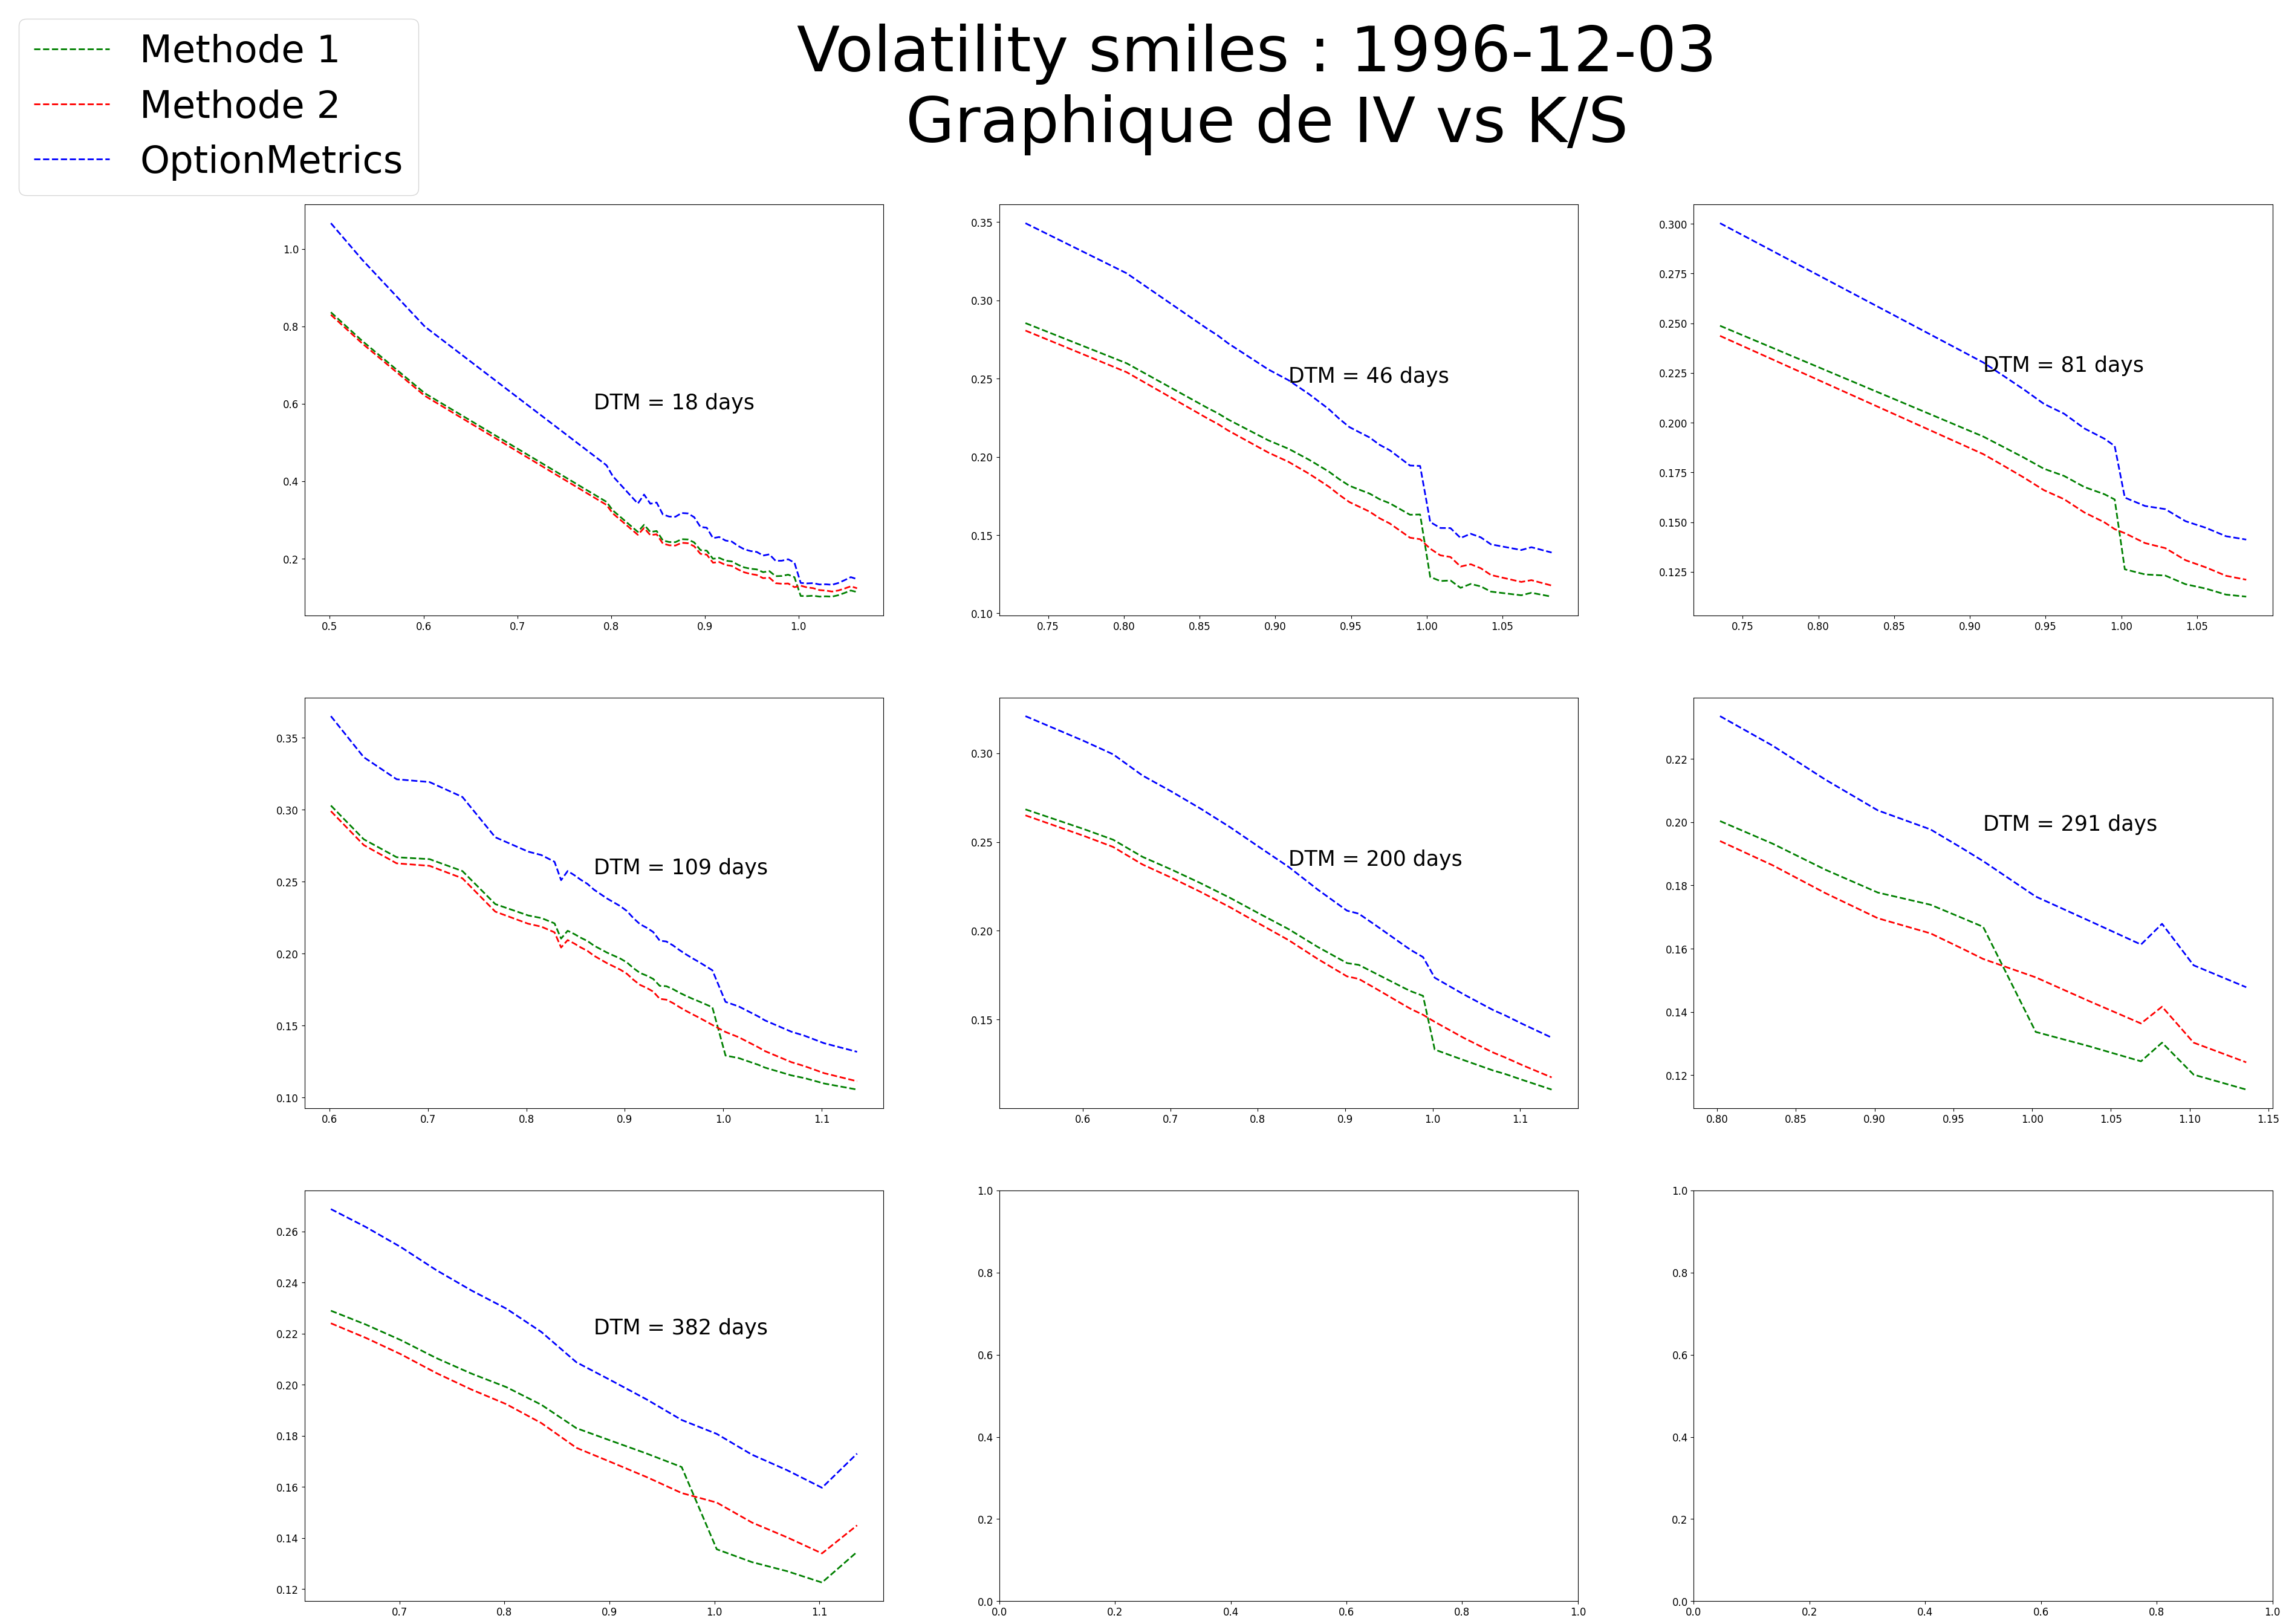

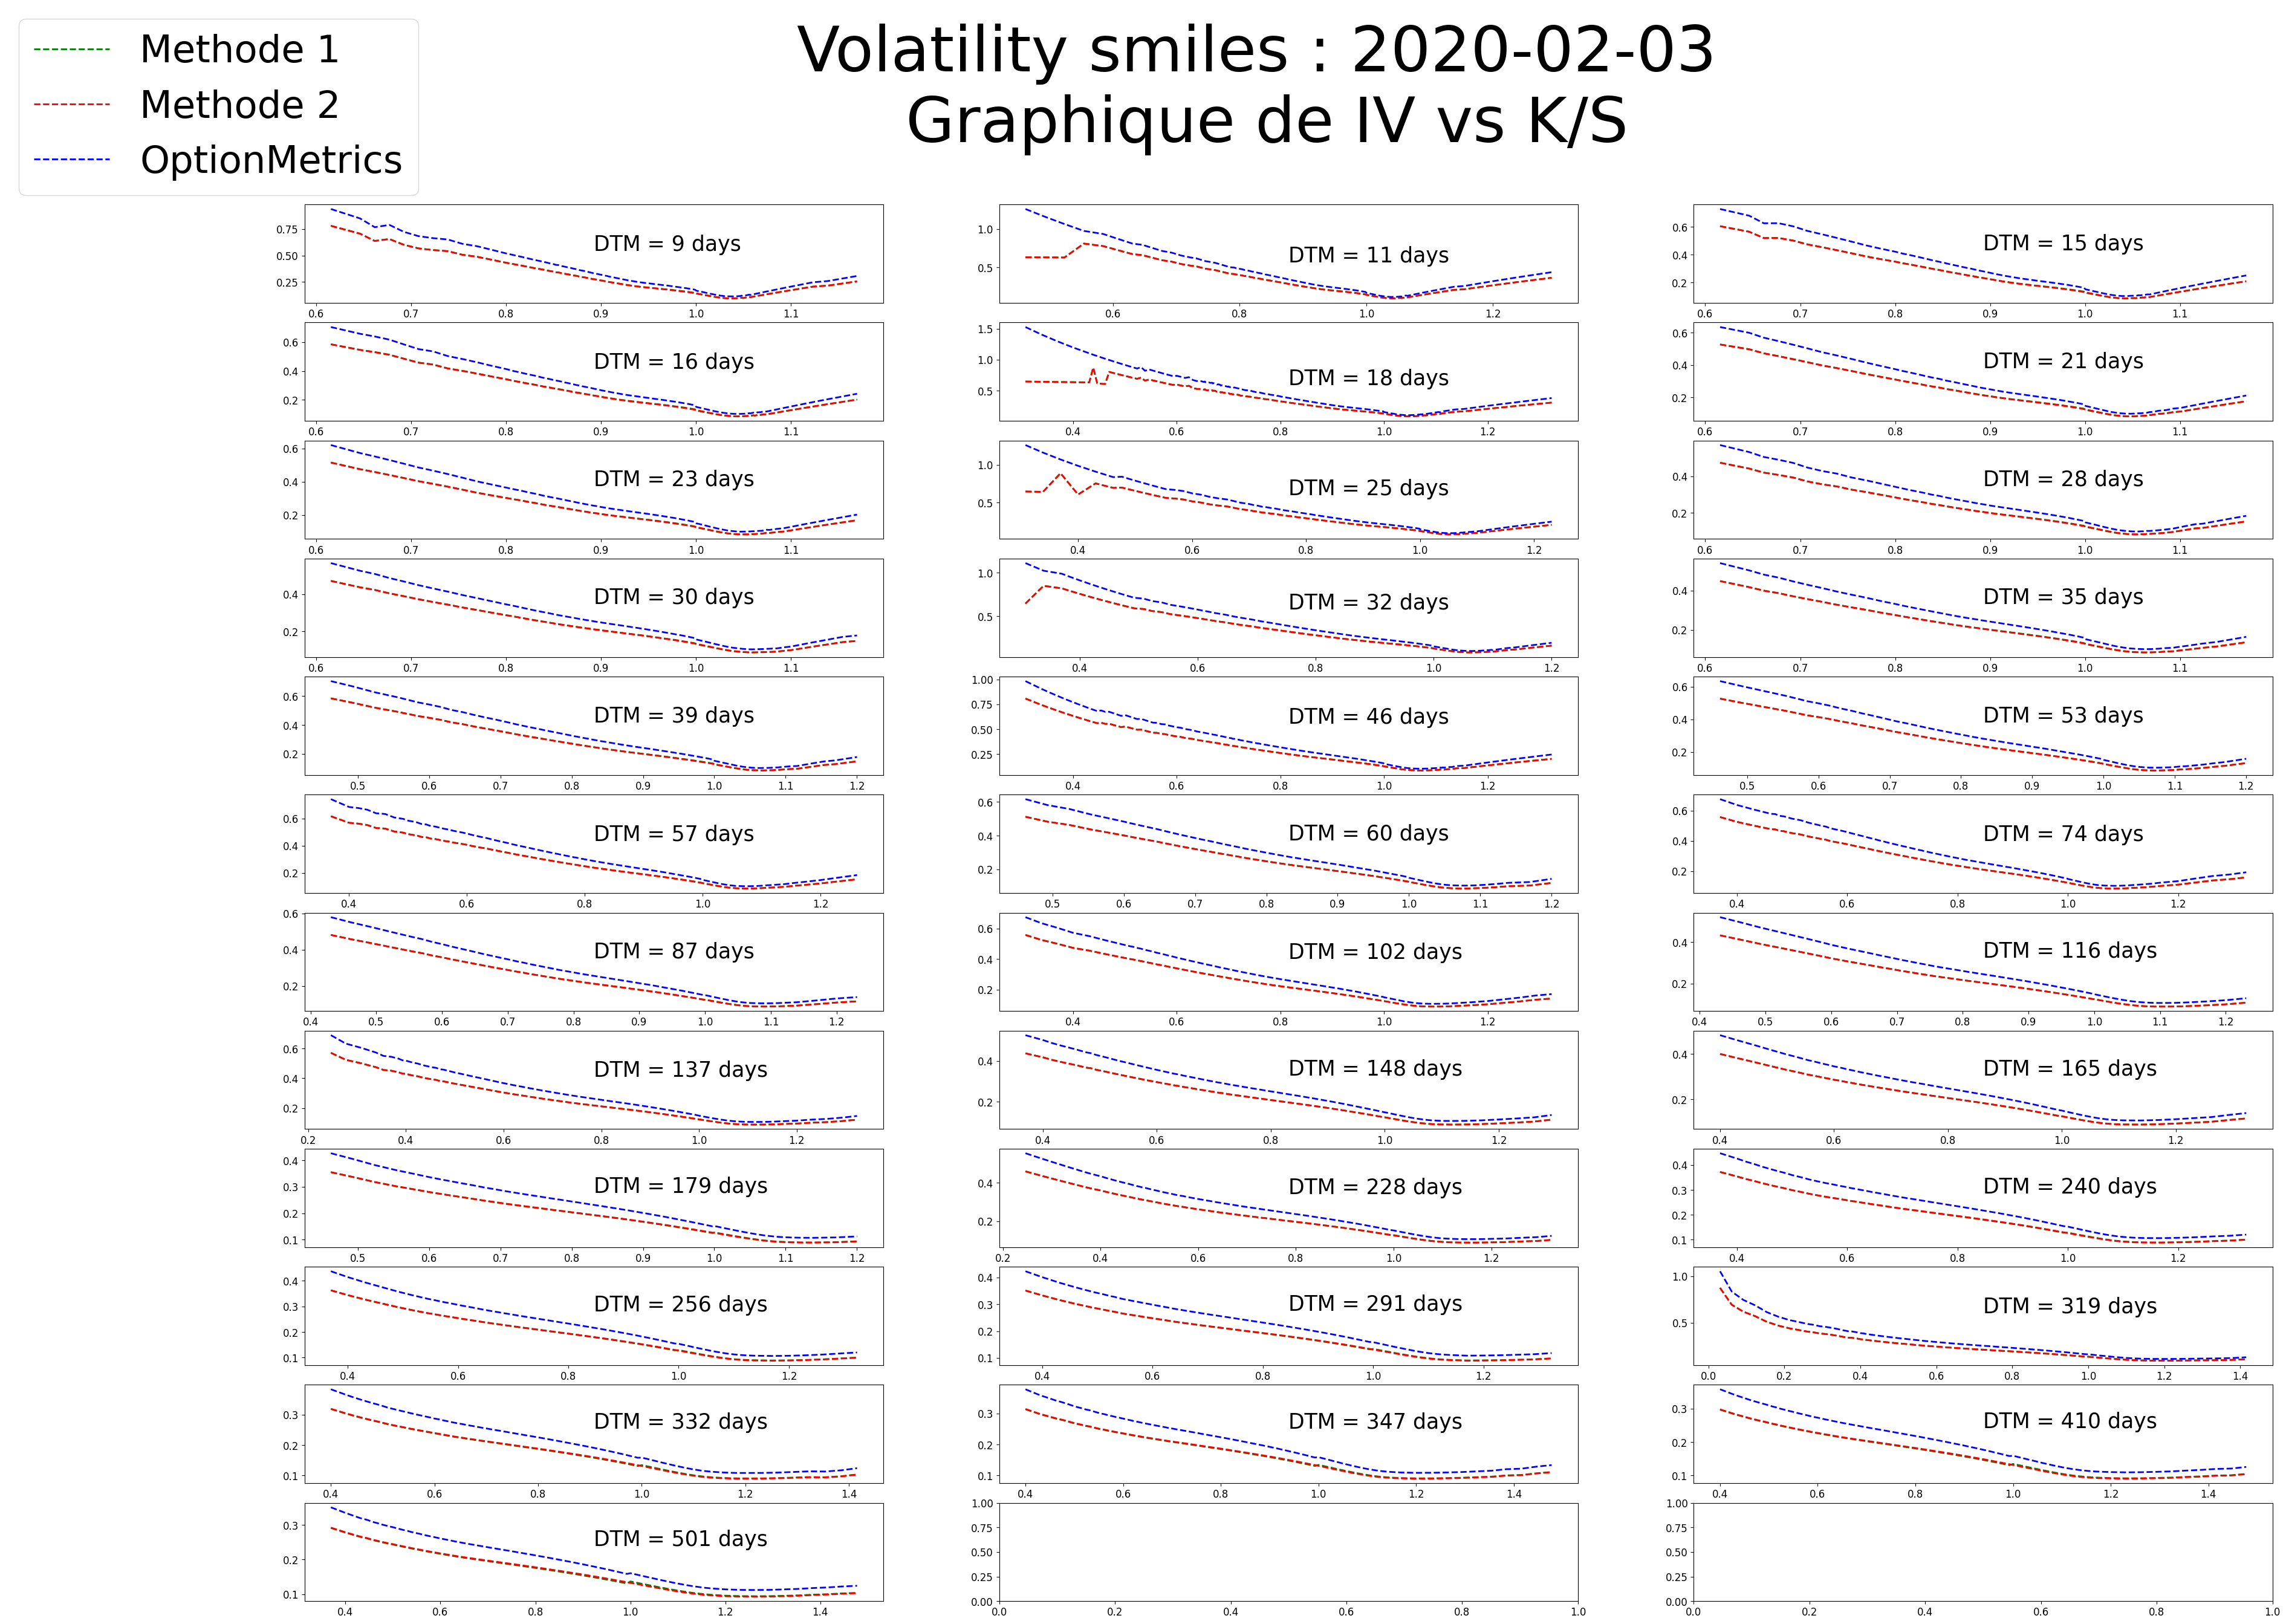

In [12]:
# Calculer les IV pour les deux types de prix ex-dividende
impl_vol_mkt = bms.implied_volatility(opt_price = option_info.mean_bidask,
                                      S         = [option_info.exdiv_1,option_info.exdiv_2],
                                      K         = option_info.strike_price / 1000,
                                      r         = option_info.r_f,
                                      y         = 0,
                                      T         = option_info.DTM / days_in_year,
                                      is_call   = (option_info.cp_flag == 'C'))

# Ajouter les résultats à option_info
option_info['IV_method1'] = impl_vol_mkt[0]
option_info['IV_method2'] = impl_vol_mkt[1]

# Enlever les options pour lesquelles on a une IV négatif pour une des deux méthéodes
option_info = option_info[(option_info['IV_method1'] >= 0) & (option_info['IV_method2'] >= 0)]

# Smile pour tout les maturités (pour les deux dates)
date_unique = np.unique(option_info.date)
f_plot_Q4_smiles(option_info, date_unique[0], '1996-12-03')
f_plot_Q4_smiles(option_info, date_unique[1], '2020-02-03')

# Question 5

Dans la même optique, dénotons $\tilde{R}_{t,T}^{(j)} = \exp\left\lbrace\sum_{k=1}^{T-t} r_{t+k}^{(j)} - r_f\right\rbrace$ le rendement excédentaire à terme obtenus par simulation du modèle NGARCH. Notez que le payoff actualisé d'une option peut être écrit 
\begin{align*}
  \mathcal{O}^{(j)}_{i} = e^{-r_{t,T_i} (T_i-t)}\max\left\lbrace 0, cp_i\left(F_{t,T_i} \tilde{R}_{t,T_i}^{(j)} - K\right) \right\rbrace
\end{align*}
où $cp_i = 1$ pour un call $i$ ($cp_i = -1$ pour le put $i$) de maturité $T_i$ et de strike $K_i$. Ainsi, seul $\tilde{R}_{t,T}^{(j)}$ dépend de la trajectoire simulée. En $t$, en simulant une seule fois 100,000 trajectoires de longueur $T_{max} - t$, il est donc possible de tarifer toutes les options observées ce jour là.

Procéder ainsi en utilisant l'un où l'autre des prix forward considérés en Question 3. Comparer les IV obtenues en Question 4, selon les prix de marché, avec les IV obtenus en appliquant la même méthode numérique au prix NGARCH. En particulier, tabuler les erreurs de tarifications, dans le domaine de la IV, en fonction d'intervalles de maturité et de moneyness.

In [13]:
# Simulation des returns avec le modèle GARCH pour plus grande maturité sous Q
option_info = simulate_returns(option_info, ng1996, ng2020, n_paths=100_000)

In [14]:
option_info

,date,exdate,cp_flag,strike_price,volume,best_bid,mean_bidask,open_interest,impl_volatility,DTM,S_t,y_t,r_f,F,K/F,exdiv_1,F_CBOE,exdiv_2,IV_method1,IV_method2,R_j
0,1996-12-03,1997-12-20,P,"550,000.0000",0.0000,5.6250,6.1250,"3,497.0000",0.2449,382,748.2800,0.0250,0.0556,783.9128,0.7016,720.5017,773.096,710.5599,0.2105,0.2047,"[1.0237393663375531, 1.0751915782489267, 0.934..."
1,1996-12-03,1997-12-20,P,"750,000.0000","1,118.0000",41.3750,42.3750,"2,131.0000",0.1792,382,748.2800,0.0250,0.0556,783.9128,0.9567,720.5017,773.096,710.5599,0.1638,0.1524,"[1.0237393663375531, 1.0751915782489267, 0.934..."
2,1996-12-03,1997-03-22,P,"650,000.0000",22.0000,5.6250,5.8750,"27,930.0000",0.2444,109,748.2800,0.0250,0.0553,758.1743,0.8573,740.2463,752.3045,734.5153,0.2055,0.1985,"[1.077681084761861, 0.9855708607493502, 1.0152..."
3,1996-12-03,1997-02-22,P,"700,000.0000",505.0000,9.6250,9.8750,"1,182.0000",0.2168,81,748.2800,0.0250,0.0554,755.6285,0.9264,742.3017,749.8728,736.6475,0.1825,0.1725,"[1.0678913298245176, 1.0422229379301418, 1.017..."
4,1996-12-03,1997-06-21,C,"685,000.0000",0.0000,87.3750,87.8750,419.0000,0.2001,200,748.2800,0.0250,0.0552,766.4428,0.8937,733.6054,759.2723,726.7421,0.1475,0.1769,"[1.0508974282574148, 0.9821315588562647, 0.975..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10882,2020-02-03,2020-12-31,P,"3,650,000.0000",0.0000,415.4000,424.5000,0.0000,0.1064,332,"3,248.9200",0.0184,0.0154,"3,236.1878",1.1279,"3,171.1243","3,244.7443","3,179.5088",0.0875,0.0963,"[1.1381835898977195, 1.1482795594421709, 0.563..."
10883,2020-02-03,2020-12-31,P,"3,700,000.0000",0.0000,457.2000,466.3500,0.0000,0.1015,332,"3,248.9200",0.0184,0.0154,"3,236.1878",1.1433,"3,171.1243","3,244.7443","3,179.5088",0.0833,0.0946,"[1.1381835898977195, 1.1482795594421709, 0.563..."
10884,2020-02-03,2020-12-31,P,"3,750,000.0000",0.0000,500.8000,509.9000,0.0000,0.0953,332,"3,248.9200",0.0184,0.0154,"3,236.1878",1.1588,"3,171.1243","3,244.7443","3,179.5088",0.0781,0.0931,"[1.1381835898977195, 1.1482795594421709, 0.563..."
10885,2020-02-03,2020-12-31,P,"3,800,000.0000",0.0000,545.9000,555.0000,0.0000,0.0866,332,"3,248.9200",0.0184,0.0154,"3,236.1878",1.1742,"3,171.1243","3,244.7443","3,179.5088",0.0708,0.0923,"[1.1381835898977195, 1.1482795594421709, 0.563..."


In [15]:
option_info = calculate_option_prices(option_info, ng1996, ng2020)

In [16]:
option_info

,date,exdate,cp_flag,strike_price,volume,best_bid,mean_bidask,open_interest,impl_volatility,DTM,S_t,y_t,r_f,F,K/F,exdiv_1,F_CBOE,exdiv_2,IV_method1,IV_method2,R_j,Option_price
0,1996-12-03,1997-12-20,P,"550,000.0000",0.0000,5.6250,6.1250,"3,497.0000",0.2449,382,748.2800,0.0250,0.0556,783.9128,0.7016,720.5017,773.096,710.5599,0.2105,0.2047,"[1.0237393663375531, 1.0751915782489267, 0.934...",1.1104
1,1996-12-03,1997-12-20,P,"750,000.0000","1,118.0000",41.3750,42.3750,"2,131.0000",0.1792,382,748.2800,0.0250,0.0556,783.9128,0.9567,720.5017,773.096,710.5599,0.1638,0.1524,"[1.0237393663375531, 1.0751915782489267, 0.934...",32.445
2,1996-12-03,1997-03-22,P,"650,000.0000",22.0000,5.6250,5.8750,"27,930.0000",0.2444,109,748.2800,0.0250,0.0553,758.1743,0.8573,740.2463,752.3045,734.5153,0.2055,0.1985,"[1.077681084761861, 0.9855708607493502, 1.0152...",1.004
3,1996-12-03,1997-02-22,P,"700,000.0000",505.0000,9.6250,9.8750,"1,182.0000",0.2168,81,748.2800,0.0250,0.0554,755.6285,0.9264,742.3017,749.8728,736.6475,0.1825,0.1725,"[1.0678913298245176, 1.0422229379301418, 1.017...",3.9626
4,1996-12-03,1997-06-21,C,"685,000.0000",0.0000,87.3750,87.8750,419.0000,0.2001,200,748.2800,0.0250,0.0552,766.4428,0.8937,733.6054,759.2723,726.7421,0.1475,0.1769,"[1.0508974282574148, 0.9821315588562647, 0.975...",78.6263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10882,2020-02-03,2020-12-31,P,"3,650,000.0000",0.0000,415.4000,424.5000,0.0000,0.1064,332,"3,248.9200",0.0184,0.0154,"3,236.1878",1.1279,"3,171.1243","3,244.7443","3,179.5088",0.0875,0.0963,"[1.1381835898977195, 1.1482795594421709, 0.563...",483.7267
10883,2020-02-03,2020-12-31,P,"3,700,000.0000",0.0000,457.2000,466.3500,0.0000,0.1015,332,"3,248.9200",0.0184,0.0154,"3,236.1878",1.1433,"3,171.1243","3,244.7443","3,179.5088",0.0833,0.0946,"[1.1381835898977195, 1.1482795594421709, 0.563...",519.1368
10884,2020-02-03,2020-12-31,P,"3,750,000.0000",0.0000,500.8000,509.9000,0.0000,0.0953,332,"3,248.9200",0.0184,0.0154,"3,236.1878",1.1588,"3,171.1243","3,244.7443","3,179.5088",0.0781,0.0931,"[1.1381835898977195, 1.1482795594421709, 0.563...",556.0787
10885,2020-02-03,2020-12-31,P,"3,800,000.0000",0.0000,545.9000,555.0000,0.0000,0.0866,332,"3,248.9200",0.0184,0.0154,"3,236.1878",1.1742,"3,171.1243","3,244.7443","3,179.5088",0.0708,0.0923,"[1.1381835898977195, 1.1482795594421709, 0.563...",594.4674


In [ ]:
impl_vol_ng = bms.implied_volatility(opt_price = option_info.Option_price, 
                                     S         = option_info.exdiv_2, 
                                     K         = option_info.strike_price / 1000, 
                                     r         = option_info.r_f, 
                                     y         = 0, 
                                     T         = option_info.DTM / days_in_year, 
                                     is_call   = (option_info.cp_flag == 'C'))

option_info['IV_NGARCH'] = impl_vol_ng
option_info[['date','exdate','cp_flag', 'strike_price','impl_volatility','IV_method1','IV_method2','IV_NGARCH']]

/Users/thomasvaudescal/opt/miniconda3/envs/TP2/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
/Users/thomasvaudescal/opt/miniconda3/envs/TP2/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
